**Really should be called `clean latent heat flux data`**

This notebook:
- Examines how blowing snow fluxes and "bad" EC data (data with quality control flags raised) are related
- Removes LH flux data points from the 5 minute dataset that have flags raised for >10% of the instantaneous (20hz) measurements included in each 5-minute Reynolds average
  - Analyzes how different thresholds effect sublimation estimates
- Removes LH flux data points outside a threshold 5*$\sigma$ where $\sigma$ is standard deviation
- Interpolate data gaps upto 1-hour long
  - Analyzes how changing the "max gap size interpolated" effects sublimation estimates
- Adds "Cumulative sublimation measured"  measurements to the 5 minute dataset, and saves it to disc

In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')

from sublimpy import turbulence
import matplotlib.pyplot as plt
from sublimpy import tidy
import metpy.constants

# Open data

## Open SOS Measurement Dataset

In [2]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Set file path to save the modified tidy_df dataset

In [3]:
output_fn = f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet'

## Identify the relevant turbulent flux measurement variables

In [4]:
ec_lhflux_and_counts_variables = [
    # ('w_h2o__2m_c', 'counts_2m_c_1'), 
    ('w_h2o__3m_c', 'counts_3m_c_1'), 
    ('w_h2o__5m_c', 'counts_5m_c_1'), 
    ('w_h2o__10m_c', 'counts_10m_c_1'), 
    ('w_h2o__15m_c', 'counts_15m_c_1'), 
    ('w_h2o__20m_c', 'counts_20m_c_1'), 


    # ('w_h2o__1m_d', 'counts_1m_d_1'), 
    ('w_h2o__3m_d', 'counts_3m_d_1'), 
    ('w_h2o__10m_d', 'counts_10m_d_1'), 
      
    # ('w_h2o__1m_ue', 'counts_1m_ue_1'), 
    ('w_h2o__3m_ue', 'counts_3m_ue_1'), 
    ('w_h2o__10m_ue', 'counts_10m_ue_1'), 


    # ('w_h2o__1m_uw',  'counts_1m_uw_1'), 
    ('w_h2o__3m_uw', 'counts_3m_uw_1'), 
    ('w_h2o__10m_uw', 'counts_10m_uw_1'), 
]
ec_lhflux_variables = list(zip(*ec_lhflux_and_counts_variables))[0]

# Analyze the quality of the EC dataset

## Compare data collection quality with blowing snow fluxes

In [5]:
counts_variables = list(list(zip(*ec_lhflux_and_counts_variables))[1])

In [6]:
src = tidy_df[tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])]
src = src[src.value > 0]
bs_times = set(src.time.unique())
nobs_times = list(set(tidy_df.time.unique()) - bs_times)
bs_times = list(bs_times)

In [7]:
src = tidy_df[tidy_df.variable == 'counts_3m_c_1']
src = pd.concat([
    src[src.time.isin(bs_times)].assign(bs = 'blowing snow'),
    src[src.time.isin(nobs_times)].assign(bs = 'no blowing snow')
])
src

,time,variable,value,height,tower,measurement,bs
74866,2022-12-02 08:30:00,counts_3m_c_1,35841.0,3.0,c,eddy covariance h2o high rate count,blowing snow
76122,2022-12-02 09:00:00,counts_3m_c_1,35821.0,3.0,c,eddy covariance h2o high rate count,blowing snow
76156,2022-12-02 09:30:00,counts_3m_c_1,35854.0,3.0,c,eddy covariance h2o high rate count,blowing snow
77418,2022-12-02 10:00:00,counts_3m_c_1,35938.0,3.0,c,eddy covariance h2o high rate count,blowing snow
77484,2022-12-02 10:30:00,counts_3m_c_1,35940.0,3.0,c,eddy covariance h2o high rate count,blowing snow
...,...,...,...,...,...,...,...
5113085,2023-05-09 21:30:00,counts_3m_c_1,36000.0,3.0,c,eddy covariance h2o high rate count,no blowing snow
5113462,2023-05-09 22:00:00,counts_3m_c_1,36000.0,3.0,c,eddy covariance h2o high rate count,no blowing snow
5114281,2023-05-09 22:30:00,counts_3m_c_1,36000.0,3.0,c,eddy covariance h2o high rate count,no blowing snow
5115163,2023-05-09 23:00:00,counts_3m_c_1,36000.0,3.0,c,eddy covariance h2o high rate count,no blowing snow


In [8]:
src.query("variable == 'counts_3m_c_1'").query("value < 5400")['bs'].value_counts()

bs
no blowing snow    642
blowing snow        38
Name: count, dtype: int64

In [9]:
alt.Chart(src.query("variable == 'counts_3m_c_1'")).mark_boxplot(outliers=True).encode(
    alt.X("bs:O"),
    alt.Y("value:Q")
)

alt.Chart(...)

In [10]:
import datetime as dt

In [11]:
blowing_snow_vs_counts_src =     tidy_df[tidy_df.variable.isin(['SF_avg_2m_ue', 'SF_avg_1m_ue', 'counts_3m_c_1', 'counts_20m_c_1'])].pivot(
        index='time',
        columns='variable',
        values='value'
    ).reset_index()
blowing_snow_vs_counts_src['Dec 22'] = blowing_snow_vs_counts_src.time.dt.date == dt.date(2022, 12, 22)

rule = alt.Chart().transform_calculate(rule='32400').mark_rule(strokeDash=[4,2]).encode(y='rule:Q')

counts_and_blowingsnow_3m_c_plot = (
    alt.Chart(
        blowing_snow_vs_counts_src.query("SF_avg_1m_ue>0")
    ).mark_circle(size=10).encode(
        alt.X("SF_avg_1m_ue").scale(type='log').title([
            "Blowing snow flux (g/m^2/s)",
            "0-1m FlowCapt sensor"
        ]),
        alt.Y("counts_3m_c_1").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]),
        alt.Color("Dec 22:N").title("On Dec. 22"),
        tooltip='time'
    ).properties(width=200, height=200)+rule | alt.Chart(
        blowing_snow_vs_counts_src.query("SF_avg_2m_ue>0")
    ).mark_circle(size=10).encode(
        alt.X("SF_avg_2m_ue").scale(type='log').title([
            "Blowing snow flux (g/m^2/s)",
            "1-2m FlowCapt sensor"
        ]),
        alt.Y("counts_3m_c_1").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]),
        alt.Color("Dec 22:N").title("On Dec. 22"),
        tooltip='time'
    ).properties(width=200, height=200)+rule
)
counts_and_blowingsnow_3m_c_plot.save("counts_and_blowingsnow_3m_c_plot.png", ppi=200)
counts_and_blowingsnow_3m_c_plot

alt.HConcatChart(...)

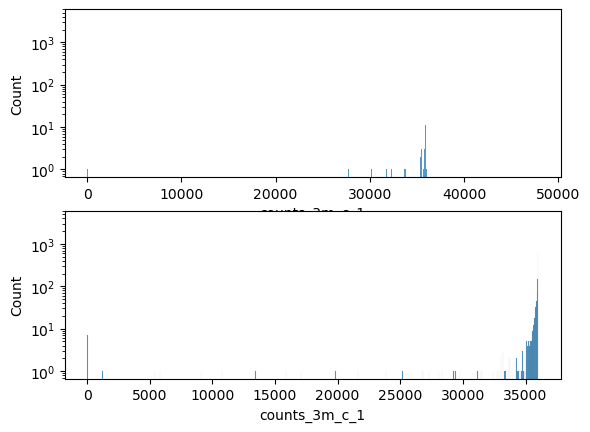

In [12]:
import seaborn as sns
fig, axes = plt.subplots(2,1, sharey=True)
sns.histplot(
    blowing_snow_vs_counts_src.query("SF_avg_1m_ue == 0")['counts_3m_c_1'],
    ax=axes[0]
)
sns.histplot(
    blowing_snow_vs_counts_src.query("SF_avg_1m_ue > 0")['counts_3m_c_1'],
    ax=axes[1]
)
plt.yscale('log')

In [13]:
alt.Chart(
    blowing_snow_vs_counts_src.query("SF_avg_1m_ue == 0")
).mark_bar(size=10).encode(
    alt.X("counts_3m_c_1:Q").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]).bin(maxbins=1000),
    alt.Y("count():Q"),
)

alt.Chart(...)

In [14]:

alt.Chart(
    blowing_snow_vs_counts_src.query("SF_avg_1m_ue == 0")
).mark_circle(size=10).encode(
    alt.X("counts_3m_c_1:Q").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]).bin(),
    alt.Y("count():Q"),
    alt.Color("Dec 22:N").title("On Dec. 22"),
    tooltip='time'
).properties(width=200, height=200)+rule | alt.Chart(
    blowing_snow_vs_counts_src.query("SF_avg_2m_ue == 0")
).mark_circle(size=10).encode(
    alt.X("counts_3m_c_1:Q").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]).bin(),
    alt.Y("count():Q"),
    alt.Color("Dec 22:N").title("On Dec. 22"),
    tooltip='time'
).properties(width=200, height=200)+rule

alt.HConcatChart(...)

In [15]:
(
    alt.Chart(
        blowing_snow_vs_counts_src.query("SF_avg_1m_ue>0")
    ).mark_circle(size=10).encode(
        alt.X("SF_avg_1m_ue").scale(type='log').title([
            "Blowing snow flux (g/m^2/s)",
            "0-1m FlowCapt sensor"
        ]),
        alt.Y("counts_20m_c_1").title(["Count unflagged 20hz w'q'", "measurements, 20m Tower C"]),
        alt.Color("Dec 22:N").title("On Dec. 22"),
        tooltip='time'
    ).properties(width=200, height=200)+rule | alt.Chart(
        blowing_snow_vs_counts_src.query("SF_avg_2m_ue>0")
    ).mark_circle(size=10).encode(
        alt.X("SF_avg_2m_ue").scale(type='log').title([
            "Blowing snow flux (g/m^2/s)",
            "1-2m FlowCapt sensor"
        ]),
        alt.Y("counts_20m_c_1").title(["Count unflagged 20hz w'q'", "measurements, 20m Tower C"]),
        alt.Color("Dec 22:N").title("On Dec. 22"),
        tooltip='time'
    ).properties(width=200, height=200)+rule
)

alt.HConcatChart(...)

## Remove data points with more than 10% of the data flagged

Calculate the upper and lower thresholds for removing outliers, five times the standarad deviation - 5*$\sigma$

In [16]:
all_lhflux_measurements = tidy_df[tidy_df.variable.isin(ec_lhflux_variables)].value
# lower_threshold = all_lhflux_measurements.mean() - 5*all_lhflux_measurements.std()
# upper_threshold = all_lhflux_measurements.mean() + 5*all_lhflux_measurements.std()
# don't actually do any outlier filtering like this anymore
lower_threshold = all_lhflux_measurements.min() - 1
upper_threshold = all_lhflux_measurements.max() + 1
lower_threshold, upper_threshold

(-1.5781314373016357, 1.7120357155799866)

In [17]:
import pandas as pd
import numpy as np

good_data_fractions = [
    0, 
    0.05, 0.1, 
    0.25, 0.50, 0.75, 
    0.90, 0.95, 
    1
]
dataframes = []
for good_data_fraction in good_data_fractions:
    for flux_var, counts_var in ec_lhflux_and_counts_variables:
        flux_values = tidy_df.query(f"variable == '{flux_var}'").value.values
        nan_count_b4_processing = pd.isnull(flux_values).sum()
        new_values = turbulence.clean_eddy_covariance(
            flux_values,
            tidy_df.query(f"variable == '{counts_var}'").value.values,
            lower_threshold,
            upper_threshold,
            fraction_good_data_reqd = good_data_fraction,
            counts_per_datapoint = 36000
        )
        nan_count_after_processing = pd.isnull(new_values).sum()
        print(good_data_fraction, flux_var, nan_count_b4_processing, nan_count_after_processing)
        dataframes.append(
            pd.DataFrame.from_dict({
                flux_var: new_values,
                'good_data_fraction': np.full(len(new_values), good_data_fraction)
            })
        )

0 w_h2o__3m_c 0 0
0 w_h2o__5m_c 0 0
0 w_h2o__10m_c 0 0
0 w_h2o__15m_c 0 0
0 w_h2o__20m_c 0 0
0 w_h2o__3m_d 0 0
0 w_h2o__10m_d 0 0
0 w_h2o__3m_ue 0 0
0 w_h2o__10m_ue 0 0
0 w_h2o__3m_uw 0 0
0 w_h2o__10m_uw 0 0
0.05 w_h2o__3m_c 0 666
0.05 w_h2o__5m_c 0 343
0.05 w_h2o__10m_c 0 479
0.05 w_h2o__15m_c 0 149
0.05 w_h2o__20m_c 0 976
0.05 w_h2o__3m_d 0 929
0.05 w_h2o__10m_d 0 962
0.05 w_h2o__3m_ue 0 897
0.05 w_h2o__10m_ue 0 866
0.05 w_h2o__3m_uw 0 874
0.05 w_h2o__10m_uw 0 912
0.1 w_h2o__3m_c 0 672
0.1 w_h2o__5m_c 0 348
0.1 w_h2o__10m_c 0 484
0.1 w_h2o__15m_c 0 154
0.1 w_h2o__20m_c 0 1022
0.1 w_h2o__3m_d 0 942
0.1 w_h2o__10m_d 0 976
0.1 w_h2o__3m_ue 0 907
0.1 w_h2o__10m_ue 0 890
0.1 w_h2o__3m_uw 0 883
0.1 w_h2o__10m_uw 0 923
0.25 w_h2o__3m_c 0 694
0.25 w_h2o__5m_c 0 363
0.25 w_h2o__10m_c 0 507
0.25 w_h2o__15m_c 0 176
0.25 w_h2o__20m_c 0 1102
0.25 w_h2o__3m_d 0 984
0.25 w_h2o__10m_d 0 1022
0.25 w_h2o__3m_ue 0 939
0.25 w_h2o__10m_ue 0 957
0.25 w_h2o__3m_uw 0 910
0.25 w_h2o__10m_uw 0 952
0.5 w_h2o__

In [18]:
seconds_per_timestep = 60*30

variable_ls = []
height_ls = []
percent_reqd_ls = []
cumulative_sublimation_ls = []

for dataframe in dataframes:
    flux_var_name = dataframe.columns[0]
    height = int(flux_var_name.split('_')[-2].split('m')[0])
    tower = flux_var_name.split('_')[-1]
    good_data_fraction = dataframe['good_data_fraction'].iloc[0]
    new_var_name = f"cumulative_sub_measured_{height}m_{tower}"
    cumulative_sublimation_values = np.nancumsum(
        dataframe[flux_var_name]*seconds_per_timestep
    )/metpy.constants.density_water.magnitude
    ec_lhflux_variables = list(zip(*ec_lhflux_and_counts_variables))[0]
    variable_ls.append(new_var_name)
    height_ls.append(height)
    percent_reqd_ls.append(good_data_fraction)
    cumulative_sublimation_ls.append(cumulative_sublimation_values.max())

In [19]:
percentreqd_qc_df = pd.DataFrame({
    'variable': variable_ls,
    'height': height_ls,
    'percent_reqd': percent_reqd_ls,
    'cumulative_sublimation': cumulative_sublimation_ls,
})
percent_reqd_seasonal_sub_sensitivity_chart = alt.Chart(percentreqd_qc_df).mark_line(point=True).transform_filter(alt.datum.height > 1).encode(
    alt.X("percent_reqd:Q").title("% 'good' data req'd per 5min average"),
    alt.Y("cumulative_sublimation:Q").title("Seasonal sublimation (mm)"),
    alt.Color("height:O").scale(scheme='viridis'),
    detail = 'variable:N',
    tooltip = 'variable:N'
)
percent_reqd_seasonal_sub_sensitivity_chart.save("percent_reqd_seasonal_sub_sensitivity_chart.png", ppi=200)
percent_reqd_seasonal_sub_sensitivity_chart

alt.Chart(...)

## Select our data-required value

In [20]:
dataframes = [df for df in dataframes if df['good_data_fraction'].iloc[0] == 0.90]

## Examine how calculated cumulative sublimation values var for different interpolation-window-limits, substitute clean data for old/dirty date (using 12-timestep gap limit), and add cumulative sublimation values to the dataset

In [21]:
seconds_per_timestep = 60*30

flux_var_name_ls = []
height_ls = []
interp_window_limit_ls = []
cumsum_with_interp_ls = []

for dataframe in dataframes:
    flux_var_name = dataframe.columns[0]
    height = int(flux_var_name.split('_')[-2].split('m')[0])
    tower = flux_var_name.split('_')[-1]
    new_var_name = f"cumulative_sub_measured_{height}m_{tower}"
    # Print calculated cumulative sublimation values for different interpolation-window-limits
    for interp_window_limit in [None, 1, 2, 5, 10, 12, 20, 30, 80, 100, 200, 300, 800, 1000]:
            flux_var_name_ls.append(flux_var_name)
            height_ls.append(height)
            interp_window_limit_ls.append(interp_window_limit)
            cumsum_with_interp_ls.append((np.nancumsum(
                (dataframe[flux_var_name]*seconds_per_timestep).interpolate(method='linear', limit=interp_window_limit)
            )/metpy.constants.density_water.magnitude).max()
        )
    
    # remove the old flux values
    tidy_df = tidy_df[tidy_df.variable != flux_var_name]
    
    # # add the new (cleaned) flux values
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        dataframe[flux_var_name].interpolate(method='linear', limit=2),
        flux_var_name,
        'w_h2o_',
        height,
        tower
    )
    # add the cumulative calculations values
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        (
              np.nancumsum(
                (dataframe[flux_var_name]*seconds_per_timestep).interpolate(method='linear', limit=2)
            )/metpy.constants.density_water.magnitude
        ),
        new_var_name,
        "Cumulative sublimation measured",  
        height,
        tower
    )

In [22]:
(dataframe[flux_var_name]*seconds_per_timestep).interpolate(method='linear', limit=2)

0        9.333149
1        0.044887
2        0.020472
3       -4.655190
4       -0.451634
          ...    
7723    32.689597
7724    22.932914
7725    15.474623
7726    22.675197
7727    10.500302
Name: w_h2o__10m_uw, Length: 7728, dtype: float64

In [23]:
gapsize_qc_df= pd.DataFrame({
    'variable': flux_var_name_ls,
    'height': height_ls,
    'max_interp_limit': interp_window_limit_ls,
    'cumulative_sub': cumsum_with_interp_ls,
})

alt.Chart(gapsize_qc_df).mark_line(point=True).transform_filter(alt.datum.height > 1).encode(
    alt.X("max_interp_limit:Q").title("max gap size for interpolation").scale(type='log'),
    alt.Y("cumulative_sub:Q").title("Seasonal sublimation (mm)"),
    alt.Color("height:O").scale(scheme='viridis'),
    detail = 'variable:N',
    tooltip='variable:N'
)

alt.Chart(...)

In [24]:
data_clean_steps_df = pd.merge(
    percentreqd_qc_df.query("percent_reqd == 0")[['variable','cumulative_sublimation']].rename(
        columns = {'cumulative_sublimation': 'cumulative_sublimation_raw'}
    ),
    gapsize_qc_df.assign(variable = gapsize_qc_df.variable.str.replace(
        'w_h2o__', 'cumulative_sub_measured_'
    )).query("max_interp_limit == 2").rename(
        columns = {'cumulative_sub': 'cumulative_sublimation_gapfilled'}
    ),
    on='variable'
).merge(
    percentreqd_qc_df.query("percent_reqd == 0.9")[['variable','cumulative_sublimation']].rename(
        columns = {'cumulative_sublimation': 'cumulative_sublimation_filtered'}
    ),
    on='variable'
)

In [25]:
data_clean_steps_df['tower'] = data_clean_steps_df.variable.apply(lambda s:s.split('_')[-1])
data_clean_steps_df = data_clean_steps_df[
    ['variable', 'tower', 'height', 'cumulative_sublimation_raw', 'cumulative_sublimation_filtered', 'cumulative_sublimation_gapfilled']
].round(2)
data_clean_steps_df = data_clean_steps_df.rename(columns={
    'cumulative_sublimation_raw': 'raw',
    'cumulative_sublimation_filtered': 'filtered',
    'cumulative_sublimation_gapfilled': 'gapfilled',
})

In [26]:
data_clean_steps_df

,variable,tower,height,raw,filtered,gapfilled
0,cumulative_sub_measured_3m_c,c,3,36.09,34.71,34.97
1,cumulative_sub_measured_5m_c,c,5,40.02,37.32,37.48
2,cumulative_sub_measured_10m_c,c,10,38.76,37.91,38.24
3,cumulative_sub_measured_15m_c,c,15,32.13,27.30,28.27
4,cumulative_sub_measured_20m_c,c,20,27.96,25.23,26.99
5,cumulative_sub_measured_3m_d,d,3,34.69,34.72,34.95
6,cumulative_sub_measured_10m_d,d,10,35.96,33.31,33.98
7,cumulative_sub_measured_3m_ue,ue,3,36.13,33.97,34.44
8,cumulative_sub_measured_10m_ue,ue,10,31.01,29.25,30.12
9,cumulative_sub_measured_3m_uw,uw,3,35.51,33.83,34.11


In [27]:
vars = [
    'raw',	'filtered',	'gapfilled'
    ]
data_cleaning_steps_affects_chart = alt.Chart(data_clean_steps_df).mark_line().transform_fold(
    vars
).encode(
    alt.Y("key:O", sort=vars).title(None),
    alt.X("value:Q").title("Cumulatuve sublimation (mm)"),
    alt.Color('height:N'),
    detail = 'variable'
)
data_cleaning_steps_affects_chart.save("data_cleaning_steps_affects_chart.png", ppi=200)
data_cleaning_steps_affects_chart

alt.Chart(...)

In [28]:
tidy_df.measurement.unique()

array(['u_u_', 'potential virtual temperature', 'specific humidity',
       'air density', 'mixing ratio', 'vapor pressure', 'u_w_',
       'potential temperature', 'v_w_', 'virtual temperature', 'w_w_',
       'v_v_', 'v_h2o_', 'u_h2o_', 'v_tc_', 'u_tc_', 'w_tc_', 'w_h2o_',
       'Obukhov length', 'eddy covariance h2o high rate count',
       'eddy covariance co2 high rate count',
       'eddy covariance momentum high rate count', 'surface temperature',
       'longwave radiation outgoing', 'longwave radiation incoming',
       'snow depth', 'turbulent kinetic energy', 'shear velocity',
       'wind gradient', 'surface potential virtual temperature',
       'surface potential temperature', 'temperature gradient',
       'richardson number bulk', 'surface virtual temperature',
       'richardson number', 'longwave radiation net', None,
       'shortwave radiation net', 'Decoupling metric', 'wind speed',
       'wind direction', 'u', 'v', 'Water vapor density', 'w',
       'snow temper

# Save cleaned data

In [29]:
tidy_df.to_parquet(output_fn)

In [30]:
ls -lah | grep parquet

-rw-r--r--    1 elischwat  staff    29M Feb 21 16:57 coare_model_results.parquet
-rw-r--r--    1 elischwat  staff   113M Feb 21 20:58 model_results.parquet
-rw-r--r--    1 elischwat  staff    32M Feb 22 16:11 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-r--r--    1 elischwat  staff   257M Feb 20 22:02 tidy_df_20221130_20230509_noplanar_fit_ARCHIVE.parquet
-rw-r--r--    1 elischwat  staff    65M Feb 22 16:12 tidy_df_20221130_20230509_noplanar_fit_clean.parquet


# Explore the data points we left out, based on the thresholds (for filtering data) that we determined earlier
# These are the datapoints we don't trust and are excluding - we should get an idea of what's happening during these limited times
* Measurements during times where SF_avg_XX_ue measurements are > 10^0, and have “good data” counts less than 0.9*6000 
* If too much data, only remove isolated incidents (I.e. less than 2 of those data points in a row)

In [31]:
alt.Chart(
    tidy_df[
        tidy_df.variable == 'cumulative_sub_measured_10m_d'
    ].set_index('time').loc[
        "2023-04-24":"2023-04-26"
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)


alt.Chart(...)

In [32]:
bad_data = tidy_df[
    tidy_df.variable.isin(['SF_avg_2m_ue', 'SF_avg_1m_ue'])
].query("value > 1")

In [33]:
bad_data = bad_data.sort_values('time')
bad_data['month'] = bad_data.time.dt.month

In [34]:
alt.Chart(
    bad_data
).mark_tick().encode(
    alt.X("time:T").title(None),
    alt.Row("month:O").sort([12,1,2,3,4])
).resolve_scale(x='independent', y='shared').properties(width=400)

alt.Chart(...)

Select a few case studies based on the plot of bad data occurences above

In [35]:
case_study_ls = [
    ("20221213", "20221215"),
    ("20221221", "20221223"),
    ("2023-01-10 12:00:00" , "2023-01-10 14:00:00"),
    ("20230205", "20230207"),
    ("20230308", "20230310"),
    ("20230330", "20230401"),
    ("20230403", "20230404"),
    ("20230424 2300", "20230425 0200"),
    

]

In [36]:
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')

In [37]:
src = tidy_df[
        tidy_df.variable.isin(list(sum(ec_lhflux_and_counts_variables, ())) + [
            'spd_3m_c', 'spd_5m_c', 'spd_10m_c', 'spd_15m_c', 'spd_20m_c',
            'spd_3m_d', 'spd_10m_d',
            'spd_3m_ue', 'spd_10m_ue',
            'spd_3m_uw', 'spd_10m_uw',
        ])
    ].set_index('time').sort_index()
src['tower and height'] = src.apply(lambda row : row['tower'] + ' ' + str(row['height']), axis=1)

In [38]:
data_dropped_case_study_src = src[
        case_study_ls[1][0]: case_study_ls[1][1]
    ].reset_index().query("tower == 'c'").query("height == 3")

base_chart = alt.Chart().mark_line().properties(
    height = 100,
    width = 200
)
data_dropped_case_study_plot = (
    alt.layer(
        base_chart, data=data_dropped_case_study_src.query(
            "measurement == 'eddy covariance h2o high rate count'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]),
    ) & 
    alt.layer(
        base_chart, data=data_dropped_case_study_src.query(
            "measurement == 'w_h2o_'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["w'q'", "3m Tower C"]),
    ) & 
    alt.layer(
        base_chart, data=data_dropped_case_study_src.query(
            "measurement == 'wind speed'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Wind speed", "3m Tower C"]),
    )
).resolve_scale(x='shared')

In [39]:
no_data_dropped_case_study_src = src[
        case_study_ls[0][0]: case_study_ls[0][1]
    ].reset_index().query("tower == 'ue'").query("height == 10")

base_chart = alt.Chart().mark_line().properties(
    height = 100,
    width = 200
)
no_data_dropped_case_study_plot = (
    alt.layer(
        base_chart, data=no_data_dropped_case_study_src.query(
            "measurement == 'eddy covariance h2o high rate count'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Count unflagged 20hz w'q'", "measurements, 10m Tower UE"]),
    ) & 
    alt.layer(
        base_chart, data=no_data_dropped_case_study_src.query(
            "measurement == 'w_h2o_'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["w'q'", "10m Tower UE"]),
    ) & 
    alt.layer(
        base_chart, data=no_data_dropped_case_study_src.query(
            "measurement == 'wind speed'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Wind speed", "10m Tower UE"]),
    )
).resolve_scale(x='shared')

In [40]:
data_dropped_casestudies_chart = (no_data_dropped_case_study_plot | data_dropped_case_study_plot)
data_dropped_casestudies_chart.save("data_dropped_casestudies_chart.png", ppi=200)
data_dropped_casestudies_chart

alt.HConcatChart(...)

In [41]:
alt.Chart(
    src[
        case_study_ls[0][0]: case_study_ls[0][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [42]:
alt.Chart(
    src[
        case_study_ls[1][0]: case_study_ls[1][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [43]:
alt.Chart(
    src[
        case_study_ls[2][0]: case_study_ls[2][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [44]:
alt.Chart(
    src[
        case_study_ls[3][0]: case_study_ls[3][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [45]:
alt.Chart(
    src[
        case_study_ls[4][0]: case_study_ls[4][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [46]:
alt.Chart(
    src[
        case_study_ls[5][0]: case_study_ls[5][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [47]:
alt.Chart(
    src[
        case_study_ls[6][0]: case_study_ls[6][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)

In [48]:
alt.Chart(
    src[
        case_study_ls[7][0]: case_study_ls[7][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

alt.Chart(...)